# Sequential vs Functional APIs

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.models import Model

2023-12-06 15:54:45.987289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Sequential API

In [2]:
def build_model_with_sequential():
    
    # instantiate a Sequential class and linearly stack the layers of your model
    seq_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                            tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                            tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    return seq_model

## Functional API

In [3]:
def build_model_with_functional():
    
    # instantiate the input Tensor
    input_layer = tf.keras.Input(shape=(28, 28))
    
    # stack the layers using the syntax: new_layer()(previous_layer)
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    first_dense = tf.keras.layers.Dense(128, activation=tf.nn.relu)(flatten_layer)
    output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(first_dense)
    
    # declare inputs and outputs
    func_model = Model(inputs=input_layer, outputs=output_layer)
    
    return func_model

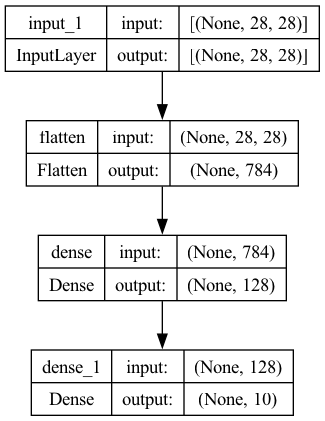

In [4]:
model = build_model_with_functional()
#model = build_model_with_sequential()

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True)

## Train the model

In [5]:
# prepare fashion mnist dataset
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0

# configure, train, and evaluate the model
model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
model.evaluate(test_images, test_labels)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4982 - accuracy: 0.8234
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3760 - accuracy: 0.8645
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3333 - accuracy: 0.8783
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3087 - accuracy: 0.8853
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3516 - accuracy: 0.8772


[0.35157591104507446, 0.8772000074386597]

# Multi-output Architecture

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

In [7]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x, stats):
    return (x - stats['mean']) / stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, history, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

In [8]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train, train_stats)
norm_test_X = norm(test, train_stats)

## Build the Model

In [9]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 128)                  1152      ['input_2[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 128)                  16512     ['dense_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 64)                   8256      ['dense_3[0][0]']             
                                                                                            

## Configuring Training Params

In [10]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the model

In [11]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 226.9253 - y1_output_loss: 103.3898 - y2_output_loss: 123.5355 - y1_output_root_mean_squared_error: 10.1681 - y2_output_root_mean_squared_error: 11.1147 - val_loss: 53.7531 - val_y1_output_loss: 17.6735 - val_y2_output_loss: 36.0797 - val_y1_output_root_mean_squared_error: 4.2040 - val_y2_output_root_mean_squared_error: 6.0066
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 36.5261 - y1_output_loss: 13.6964 - y2_output_loss: 22.8297 - y1_output_root_mean_squared_error: 3.7009 - y2_output_root_mean_squared_error: 4.7780 - val_loss: 34.1602 - val_y1_output_loss: 12.9287 - val_y2_output_loss: 21.2315 - val_y1_output_root_mean_squared_error: 3.5957 - val_y2_output_root_mean_squared_error: 4.6078
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 24.6644 - y1_output_loss: 10.0380 - y2_output_loss: 14.6264 - y1_output_root_mean_squared_error: 3.1683 - y2_output_root_mean_sq

## Evaluate Model & Plot Model Metrics

In [12]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 1.2018 - y1_output_loss: 0.2035 - y2_output_loss: 0.9983 - y1_output_root_mean_squared_error: 0.4511 - y2_output_root_mean_squared_error: 0.9991
Loss = 1.2017691135406494, Y1_loss = 0.2034924328327179, Y1_mse = 0.4511013627052307, Y2_loss = 0.9982766509056091, Y2_mse = 0.9991379380226135


5/5 [==============================] - 0s 1ms/step


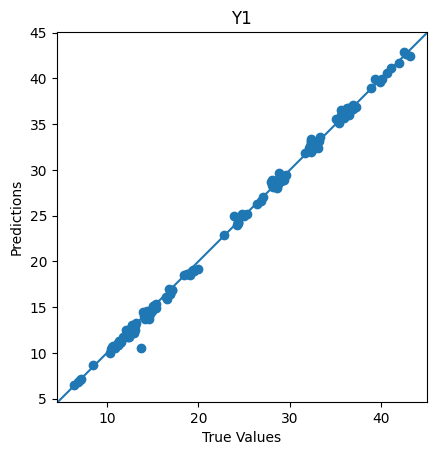

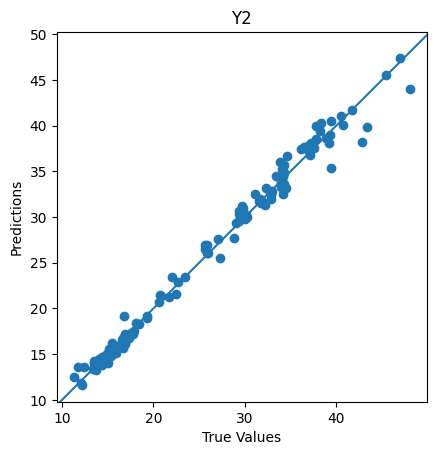

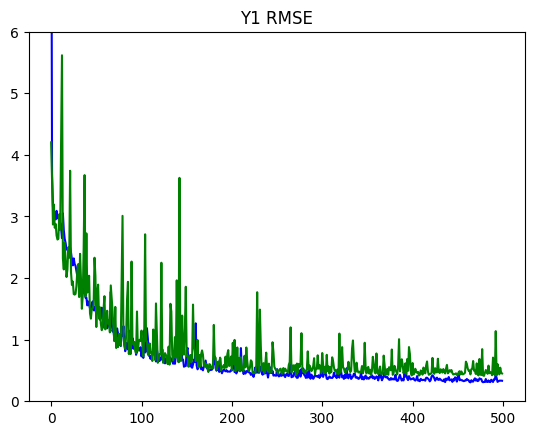

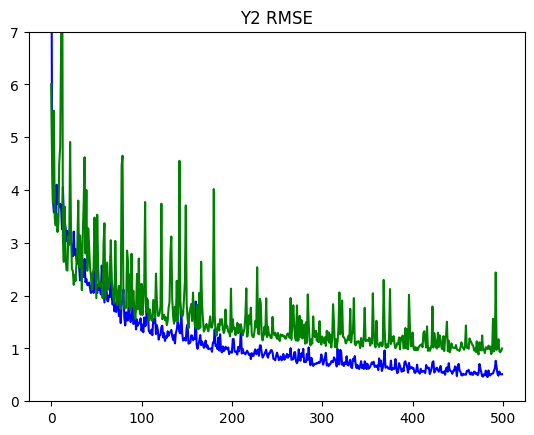

In [13]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(history=history, metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(history=history, metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

# Siamese Network - Multi-Input Architecture

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare Dataset

In [15]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [16]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

### Viz random data

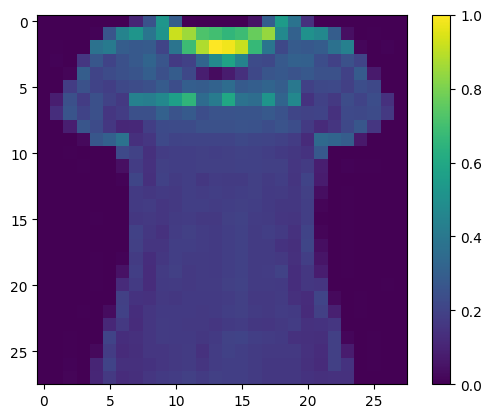

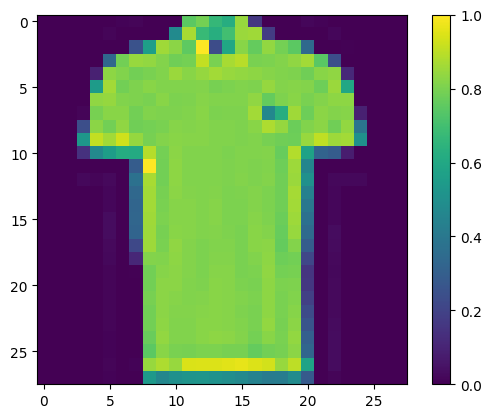

1.0


In [17]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

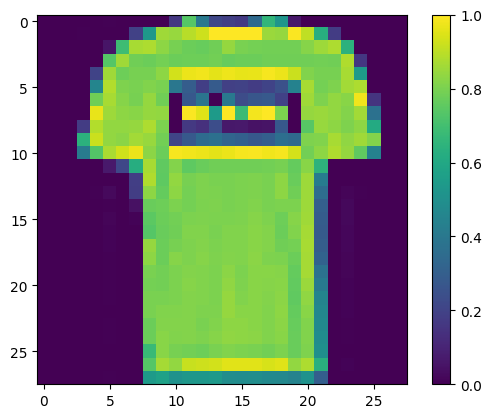

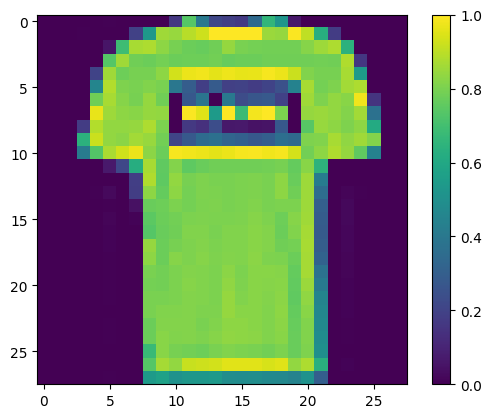

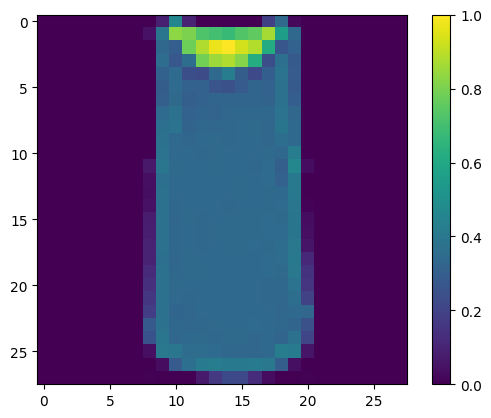

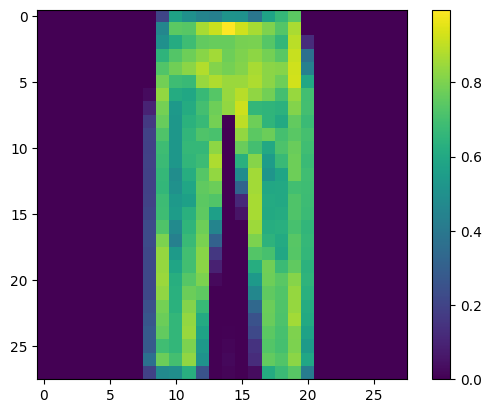

In [18]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build Model

### Base Model

In [19]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

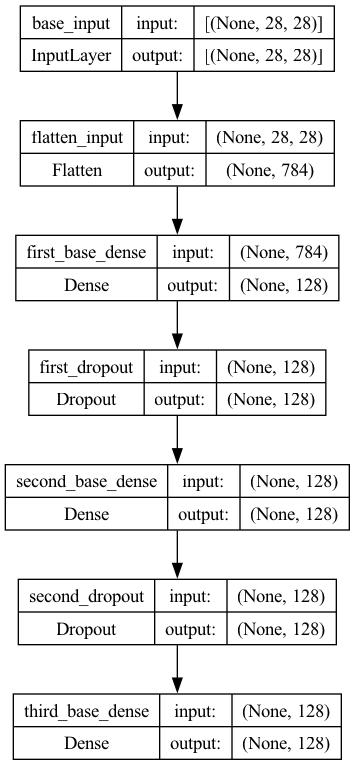

In [22]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True)

### Siamese Network

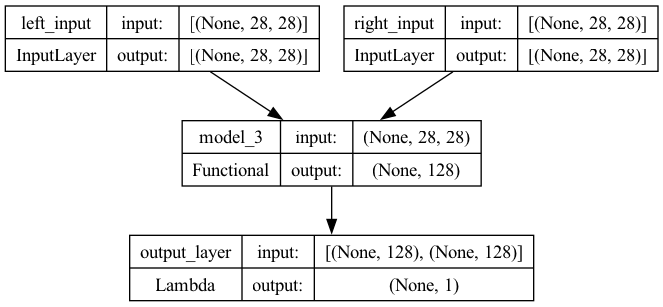

In [23]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True)

### Custom Loss Function

In [24]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [25]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1137 - val_loss: 0.0883
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0836 - val_loss: 0.0783
Epoch 3/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0740 - val_loss: 0.0746
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0690 - val_loss: 0.0695
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0661 - val_loss: 0.0699
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0635 - val_loss: 0.0694
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0616 - val_loss: 0.0670
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0600 - val_loss: 0.0664
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0589 - val_loss: 0.0677
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0579 - val_loss: 0.0646

## Model Evaluation

In [26]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [27]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step
Loss = 0.06336254626512527, Train Accuracy = 0.9395065844307384 Test Accuracy = 0.914064064064064


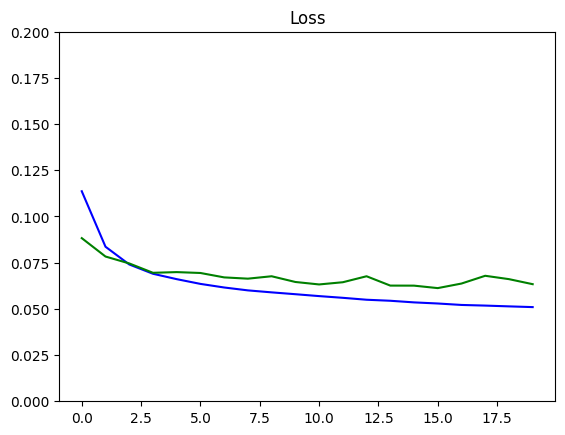

In [28]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [29]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

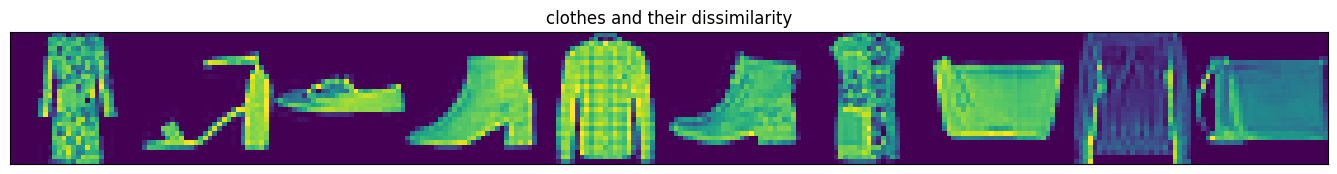

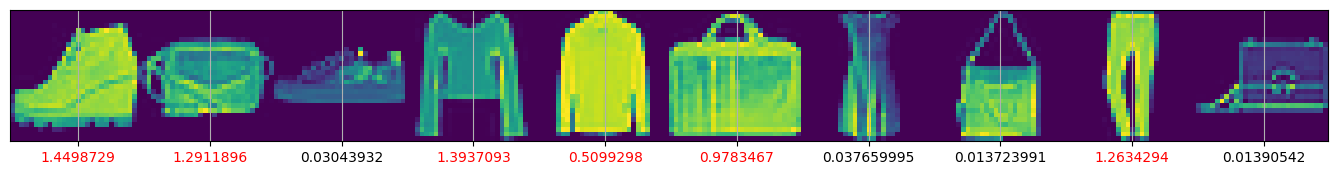

In [30]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)